Run the following command:

pip install -r requirements.txt

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import string

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hassa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [25]:
from dotenv import load_dotenv, dotenv_values
secrets = dotenv_values(".env")

#Imports the credentials for Twitter

consumerKey = secrets["consumerKey"]
consumerSecret = secrets["consumerSecret"]
accessToken = secrets["accessToken"]
accessSecret = secrets["accessSecret"]

authenticate = tweepy.OAuthHandler(consumerKey,consumerSecret)
authenticate.set_access_token(accessToken,accessSecret)

api = tweepy.API(authenticate,wait_on_rate_limit= True)

In [3]:
dataset = pd.read_csv('./datasets/kaggle_dataset.csv')
dataset.tail()

,Text,Emotion
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear
21458,"I am dismayed , but not surpris",fear


In [5]:
def missing_value(data):
    missing_data = pd.DataFrame({
        'Missing_count':data.isnull().sum(),
        'Missing_part (%)':(data.isnull().sum()/len(data))*100
    })
    missing_data = missing_data[missing_data['Missing_count']!=0]

    if len(missing_data) > 0:
        return missing_data
    else:
        return "No value is lost!!!"

In [6]:
missing_value(dataset)

'No value is lost!!!'

In [7]:
# Encoded Sentiment columns
encoder = LabelEncoder()
dataset['Label'] = encoder.fit_transform(dataset['Emotion'])
dataset.tail()

,Text,Emotion,Label
21454,Melissa stared at her friend in dism,fear,1
21455,Successive state elections have seen the gover...,fear,1
21456,Vincent was irritated but not dismay,fear,1
21457,Kendall-Hume turned back to face the dismayed ...,fear,1
21458,"I am dismayed , but not surpris",fear,1


In [8]:
num_classes = dataset.Label.nunique()
print(num_classes)

6


In [9]:
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # remove urls
    text = re.sub(r'@\w+',' ',text)         # remove mentions
    text = re.sub(r'#\w+', ' ', text)       # remove hastags
    text = re.sub('r<.*?>',' ', text)       # remove html tags
    
    # remove stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

dataset['Text'] = dataset['Text'].apply(lambda x: cleaning_text(x))

In [73]:
for i in range(5):
    print('----------------------------------------------')
    random_number=np.random.randint(0,len(dataset)-1)
    print(dataset.Text[random_number])
    print('----------------------------------------------\n')

----------------------------------------------
going trials feeling troubled something love put worship music driving really think words sing pray go
----------------------------------------------

----------------------------------------------
feel politics shocked going realm though think time important considering everything going world stage usa
----------------------------------------------

----------------------------------------------
feel irritated helpless
----------------------------------------------

----------------------------------------------
still feel scared every time go strange place
----------------------------------------------

----------------------------------------------
ignored minor tantrum jumped table beginning pace feeling agitated
----------------------------------------------



In [13]:
# Maximum sentence length
max_len_words = max(list(dataset['Text'].apply(len)))
print(max_len_words)

232


C:\Users\hassa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


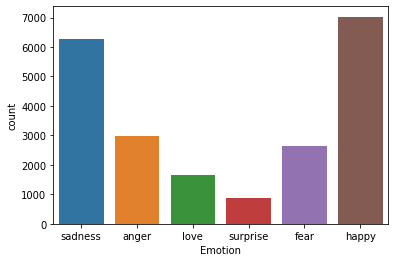

In [74]:
sns.countplot(dataset.Emotion)
plt.show()

In [ ]:
def tokenizer(x_train, y_train, max_len_word):
    # because the data distribution is imbalanced, "stratify" is used
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )

    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(dataset.Text, dataset.Label, 100)

In [18]:
model = Sequential([
    layers.Embedding(5000, 100, input_length=100),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4)),
    #layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4),
    #layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),    # or layers.Flatten()
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [97]:
import time
start = time.perf_counter()
early_stopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                         mode ="min", patience=3)

history = model.fit(X_train, y_train,
                    epochs=50, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping], 
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
537/537 [==============================] - 52s 97ms/step - loss: 0.0761 - accuracy: 0.9764 - val_loss: 0.4707 - val_accuracy: 0.8912
Epoch 2/100
537/537 [==============================] - 53s 99ms/step - loss: 0.0715 - accuracy: 0.9775 - val_loss: 0.4844 - val_accuracy: 0.8907
Epoch 3/100
537/537 [==============================] - 52s 97ms/step - loss: 0.0611 - accuracy: 0.9808 - val_loss: 0.5715 - val_accuracy: 0.8903
Epoch 4/100
537/537 [==============================] - 53s 98ms/step - loss: 0.0521 - accuracy: 0.9827 - val_loss: 0.5951 - val_accuracy: 0.8833
Elapsed 209.847 seconds.


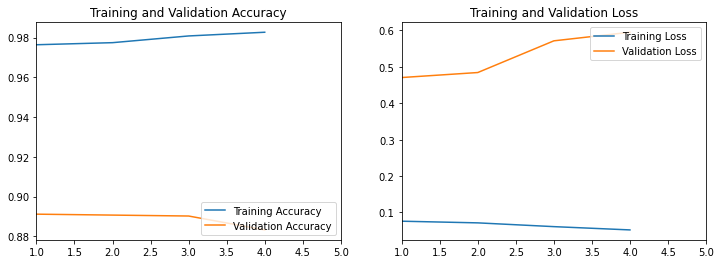

In [98]:
# Plotting accuracy and val_accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(val_acc)+1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(val_acc)+1)
plt.title('Training and Validation Loss')
plt.show()

In [96]:
mention = api.mentions_timeline()

tweet = mention[0]

tweet_id=tweet.in_reply_to_status_id

stimulus= cleaning_text(api.get_status(id=tweet_id, tweet_mode="extended").full_text)

samples_to_predict = np.array([stimulus])

tokenizer = Tokenizer(num_words=5000)
sequence_dict = tokenizer.word_index
word_dict = dict((num, val) for (val, num) in sequence_dict.items())

tokenizer.fit_on_texts(samples_to_predict)

train_sequences = tokenizer.texts_to_sequences(samples_to_predict)
train_padded = pad_sequences(train_sequences,
                                maxlen=100,
                                truncating='post',
                                padding='post')

value_arr = model.predict(train_padded)

key = {0:"sadness", 1:"anger", 2:"love", 3:"surprise", 4:"fear", 5:"happy"}

print(stimulus,": ",key[np.argmax(value_arr)])
    


I scared monster going kill me :  sadness
